In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/200kstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 366 µs, sys: 0 ns, total: 366 µs
Wall time: 680 µs


In [11]:
%%time

N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000
CPU times: user 183 ms, sys: 60 ms, total: 243 ms
Wall time: 233 ms


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275
2,0.423655,0.645894,2,0,-3.383970,-1.180936,2.203034
3,0.437587,0.891773,0,1,1.815232,-0.916623,2.731856
4,0.963663,0.383442,0,0,-1.854732,1.831724,3.686456


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,1.138110,0.501805,1.197812,1.201332,1.138916
std,0.288533,0.289177,1.717574,0.499998,2.308793,2.304341,3.307586
min,0.000003,0.000003,0.000000,0.000000,-9.004597,-8.750683,-11.960839
25%,0.249671,0.247699,0.000000,0.000000,-0.370632,-0.362303,-1.133693
50%,0.501024,0.498865,0.000000,1.000000,1.118930,1.111785,1.024670
75%,0.749132,0.750450,2.000000,1.000000,2.657538,2.658932,3.310581
max,0.999990,0.999999,5.000000,1.000000,13.559025,11.830197,15.698404


In [14]:
data['C'].value_counts()/len(data)

0    0.629620
5    0.078940
3    0.078440
4    0.077935
1    0.073780
2    0.061285
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0   -0.004243
1    1.000171
2    2.011776
3    3.036617
4    3.977432
5    5.020644
Name: ITE, dtype: float64

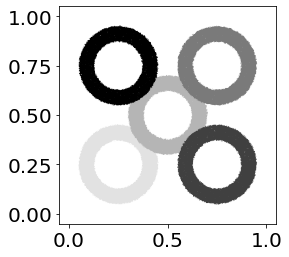

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 6min 29s, sys: 413 ms, total: 6min 30s
Wall time: 6min 32s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951
2,0.423655,0.645894,2,0,-3.383970,-1.180936,2.203034,0,2.571271,5.955240
3,0.437587,0.891773,0,1,1.815232,-0.916623,2.731856,0,-0.482122,2.297354
4,0.963663,0.383442,0,0,-1.854732,1.831724,3.686456,0,1.521292,3.376023


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        1.003534  1.007262  1.050306  0.003728  0.046772
            1        1.005037  0.971316  1.061012 -0.033721  0.055975
          1 0        0.001324  1.002671  0.993840  1.001347  0.992516
            1       -0.069415  0.957413  0.989222  1.026829  1.058637
          2 0       -0.031246  2.008624  1.960361  2.039871  1.991607
            1        0.016987  2.106250  1.964635  2.089263  1.947649
          3 0       -0.059134  3.023719  2.891618  3.082853  2.950751
            1        0.031695  3.024657  2.931404  2.992961  2.899708
          4 0        0.027710  3.985550  3.772795  3.957841  3.745086
            1       -0.044918  3.996653  3.824779  4.041572  3.869697
          5 0       -0.035521  4.998263  4.827108  5.033784  4.862629
            1        0.042682  5.050545  4.836908  5.007863  4.794226
1         0 0        0.997211  1.010953  0.936169 -0.013742  0.061042
            1        1.015795  0.984301  0.931486  0.031495  0.084309
          1 0        0.979950 -0.020410  0.118713  1.000360  0.861237
            1        0.983759  0.015969  0.074908  0.967790  0.908851
          2 0        2.001496  0.029583  0.065353  1.971913  1.936143
            1        2.027765  0.047304  0.062892  1.980461  1.964873
          3 0        3.026465  0.012989  0.046645  3.013476  2.979820
            1        3.042342  0.053961  0.020541  2.988381  3.021801
          4 0        3.947630 -0.029735  0.128423  3.977365  3.819207
            1        3.979791 -0.015345  0.153083  3.995136  3.826708
          5 0        5.001614 -0.003077  0.064298  5.004691  4.937317
            1        5.075192  0.030959  0.078348  5.044234  4.996844

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 2h 1min 50s, sys: 25.1 s, total: 2h 2min 15s
Wall time: 4min 16s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690,326,418
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951,243,384
2,0.423655,0.645894,2,0,-3.383970,-1.180936,2.203034,0,2.571271,5.955240,281,430
3,0.437587,0.891773,0,1,1.815232,-0.916623,2.731856,0,-0.482122,2.297354,387,61
4,0.963663,0.383442,0,0,-1.854732,1.831724,3.686456,0,1.521292,3.376023,188,437


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.206805,491.0,1.0,0.002455
1,1,0.059263,450.0,1.0,0.002250
2,2,-0.003443,450.0,1.0,0.002250


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


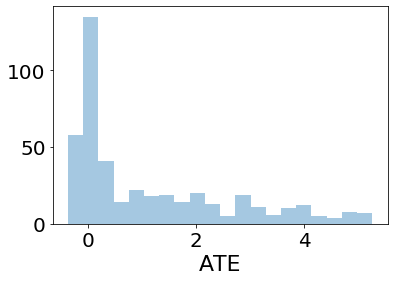

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 20
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


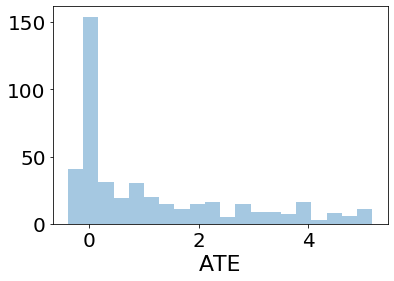

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], 
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


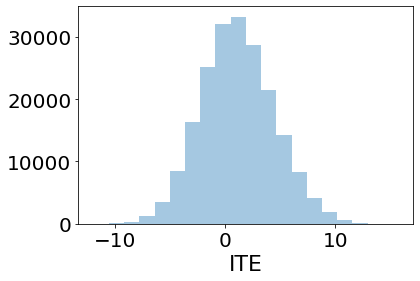

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,1.143183,453.514739,0.892414,0.002268
std,127.44999,1.478232,21.551110,0.154187,0.000108
min,0.00000,-0.370102,399.000000,0.447727,0.001995
25%,110.00000,0.019505,439.000000,0.809417,0.002195
50%,220.00000,0.384840,453.000000,1.000000,0.002265
75%,330.00000,2.025800,468.000000,1.000000,0.002340
max,440.00000,5.261410,520.000000,1.000000,0.002600


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


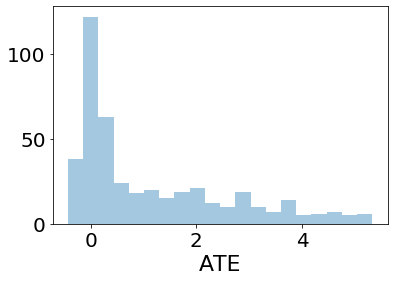

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


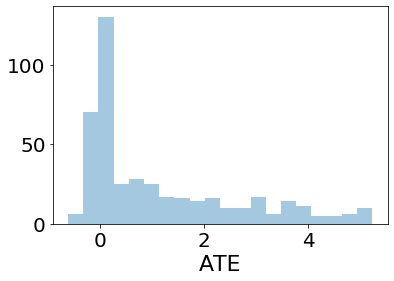

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-1,2.5)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


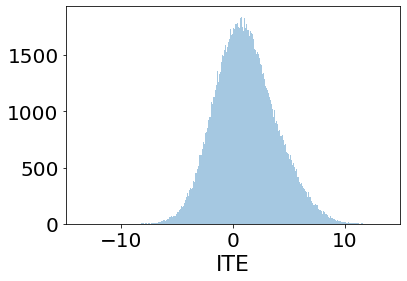

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 7
val = 5
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N, val = val )
    


Did not pick 5, it picked: 4
CPU times: user 807 ms, sys: 86.3 ms, total: 893 ms
Wall time: 1.1 s


In [34]:
box['Box-Cl2'].value_counts()

0    239
1     58
2     57
3     50
4     37
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.206805,491.0,1.0,0.002455,0
1,1,0.059263,450.0,1.0,0.002250,0


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690,326,418
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951,243,384


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5
filt41 = data2[col1] >= 2.5
filt51 = data2[col1] >= 3.5
filt61 = data2[col1] >= 4.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2
data2.loc[filt41,cluster_name1] = 3
data2.loc[filt51, cluster_name1] = 4
data2.loc[filt61, cluster_name1] = 5

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5
filt42 = data2[col2] >= 2.5
filt52 = data2[col2] >= 3.5
filt62 = data2[col2] >= 4.5


data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2
data2.loc[filt42,cluster_name2] = 3
data2.loc[filt52, cluster_name2] = 4
data2.loc[filt62, cluster_name2] = 5


#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,2.867530,0.508965,-2.358565,0,1.685840,-1.181690,326,418,0,0,1,1,1,1
1,0.602763,0.544883,0,1,2.046206,-1.220069,3.266275,0,1.095254,0.950951,243,384,3,1,0,1,0,1


### Plot reconstruction of data

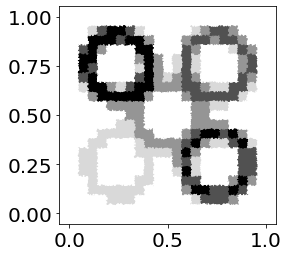

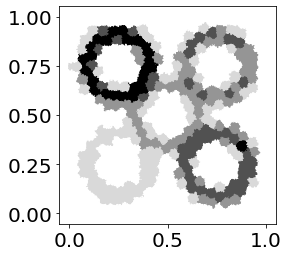

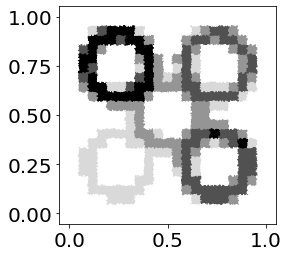

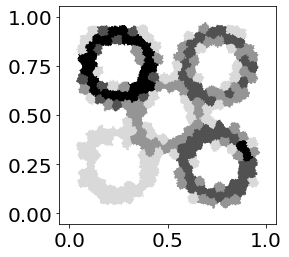

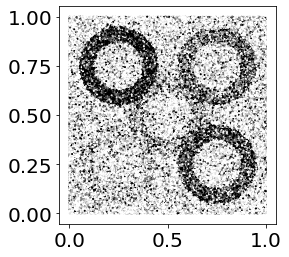

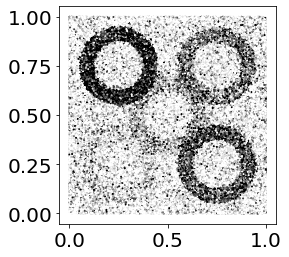

CPU times: user 1min 23s, sys: 1.6 s, total: 1min 24s
Wall time: 1min 24s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Kmeans-Cl2-err-True-ITE,0.470547,0.777444
Kmeans2-Cl2-err-True-ITE,0.480114,0.783183
Box-Cl2-err-True-ITE,0.480506,0.799434
Box2-Cl2-err-True-ITE,0.484710,0.802830
Kmeans-Cl2-err-GDBR,0.487166,0.767696
Kmeans2-Cl2-err-GDBR,0.487188,0.779148
Box-Cl2-err-GDBR,0.491336,0.793138
Box2-Cl2-err-GDBR,0.492746,0.798456
ITE-2CTrue-err-GDBR,1.390817,1.117700
ITE-2CGDBR-err-True-ITE,1.551797,1.031561


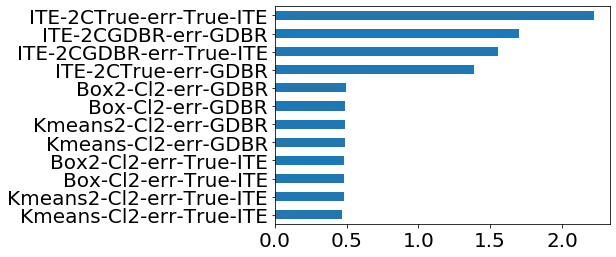

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 6, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.828706,0.078079,0.065150,0.022633,0.005432,0.0
C1 True,0.198224,0.801098,0.000678,0.000000,0.000000,0.0
C2 True,0.047320,0.120258,0.783634,0.033695,0.015093,0.0
C3 True,0.014725,0.121239,0.244454,0.619582,0.000000,0.0
C4 True,0.012960,0.061718,0.152756,0.456342,0.316225,0.0
C5 True,0.011401,0.030339,0.119394,0.147834,0.691031,0.0


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.801388,0.133549,0.051047,0.010355,0.003661,0.0
C1 True,0.116902,0.874695,0.008403,0.000000,0.000000,0.0
C2 True,0.016644,0.333361,0.593375,0.056458,0.000163,0.0
C3 True,0.010008,0.160122,0.531489,0.298381,0.000000,0.0
C4 True,0.012061,0.086162,0.167896,0.701674,0.032206,0.0
C5 True,0.004560,0.062643,0.110147,0.167532,0.655118,0.0


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.827809,0.075077,0.069693,0.021449,0.005972,0.0
C1 True,0.211033,0.788290,0.000678,0.000000,0.000000,0.0
C2 True,0.042425,0.151097,0.757689,0.033695,0.015093,0.0
C3 True,0.014725,0.113271,0.278238,0.593766,0.000000,0.0
C4 True,0.012960,0.052672,0.161802,0.713287,0.059280,0.0
C5 True,0.011401,0.030846,0.118888,0.127122,0.711743,0.0


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.789008,0.125179,0.064221,0.017225,0.004368,0.0
C1 True,0.095961,0.858430,0.045609,0.000000,0.000000,0.0
C2 True,0.016644,0.282043,0.631802,0.058252,0.011259,0.0
C3 True,0.013514,0.104475,0.378888,0.503123,0.000000,0.0
C4 True,0.011741,0.050683,0.188426,0.691923,0.057227,0.0
C5 True,0.009248,0.040664,0.081201,0.175703,0.693185,0.0


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.570868,0.132818,0.110035,0.079199,0.051523,0.055557
C1 True,0.429656,0.141027,0.134522,0.109176,0.079222,0.106397
C2 True,0.294689,0.134209,0.140981,0.132496,0.107612,0.190014
C3 True,0.185301,0.106833,0.132330,0.139852,0.131884,0.303799
C4 True,0.106820,0.081863,0.110733,0.135433,0.140373,0.424777
C5 True,0.058272,0.051051,0.077021,0.108247,0.129719,0.575690


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.580040,0.165790,0.124083,0.073870,0.035101,0.021116
C1 True,0.416915,0.188330,0.166983,0.113107,0.068176,0.046490
C2 True,0.243208,0.169617,0.190830,0.159745,0.119524,0.117076
C3 True,0.127805,0.120602,0.165796,0.185365,0.161843,0.238590
C4 True,0.063130,0.081671,0.130750,0.168089,0.181497,0.374864
C5 True,0.024196,0.038194,0.074170,0.127629,0.161262,0.574550


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.486634,0.483274,0.280262,0.498591,0.972313,1.013105,-1.113009,0.199240,0.954478,-1.328673,212.389444,217.882763,0.506622,0.462938,0.437910,0.460787,0.481665,0.350107,0.346285,0.357059,0.349047,1.046435,1.608935,0.337249,0.331157,0.347297,0.341377,1.987159,1.393271
1,0.497839,0.483819,0.702301,0.510762,1.070509,1.052765,0.948201,0.199268,1.050474,0.995155,212.851473,219.188286,1.381927,0.775684,0.723554,0.763516,0.784835,0.412374,0.424286,0.421959,0.426541,1.491207,1.115535,0.402962,0.410320,0.415406,0.421448,2.226234,1.096038
2,0.507987,0.489272,1.103438,0.505260,1.158980,1.135203,1.835827,0.200130,1.138773,1.983640,215.362108,220.794763,1.998552,1.058998,0.973855,1.038341,1.050957,0.476781,0.494734,0.486875,0.493486,1.728017,1.667101,0.469486,0.481010,0.482079,0.489589,2.404134,1.611103
3,0.526348,0.505480,1.703009,0.499463,1.307450,1.303292,2.814628,0.202911,1.312581,2.977088,222.906409,220.473085,2.738619,1.476456,1.360737,1.445193,1.450225,0.586498,0.590988,0.592167,0.591852,1.909211,1.940631,0.580322,0.575829,0.587996,0.587888,2.571694,1.897889
4,0.530140,0.523295,2.404525,0.508139,1.555581,1.479412,3.767652,0.199595,1.489779,3.970647,230.843161,221.707937,3.413914,1.947585,1.794934,1.901317,1.902128,0.701995,0.696617,0.700302,0.689840,1.888862,1.931373,0.695822,0.678341,0.695110,0.684048,2.603773,1.875774
5,0.498673,0.568246,3.563255,0.496437,1.902840,1.884689,5.694039,0.201263,1.973539,6.000117,250.018816,224.960490,4.346631,2.692281,2.513547,2.638051,2.628707,0.906323,0.849072,0.865724,0.841254,1.376518,2.436862,0.890146,0.820196,0.853327,0.826785,2.310248,2.130784


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(1.7337743267740289, 1.3170021402744803)